In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtuples as tt

from pycox.models import CoxPH
from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv
import warnings
from sklearn.model_selection import KFold
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

np.random.seed(1234)
_ = torch.manual_seed(123)

In [7]:
import numpy as np
import pandas as pd

# 设置随机种子
np.random.seed(42)

# 参数
n = 2000       # 样本量
p = 20         # 变量个数

# 生成协变量 X ~ N(0,1)
X = np.random.normal(0, 1, size=(n, p))

# AFT模型: log(T) = μ + β'X + σ*ε
# 设置参数
beta = np.zeros(p)
beta[0] = 0.5   # x1的系数
beta[1] = 0.3  # x2的系数

# 生成误差项 ε ~ G(0,1)，这里使用标准正态分布
epsilon = np.random.normal(0, 1, n)

# 计算线性预测项
linear_predictor = np.dot(X, beta)

# 生成对数生存时间
log_T = linear_predictor + epsilon

# 转换回原始尺度
T = np.exp(log_T)

# 生成独立删失时间 C ~ Exp(λc)，控制删失率
lambda_c = 0.1
C = np.random.exponential(scale=1/lambda_c, size=n)

# 观测时间与删失指示
time = np.minimum(T, C)
event = (T <= C).astype(int)

# 组织成 DataFrame
df = pd.DataFrame(X, columns=[f"x{i+1}" for i in range(p)])
df["duration"] = time
df["event"] = event

print(df.head())
print(f"删失率: {(1 - df['event'].mean()):.4f}")

         x1        x2        x3        x4        x5        x6        x7  \
0  0.496714 -0.138264  0.647689  1.523030 -0.234153 -0.234137  1.579213   
1  1.465649 -0.225776  0.067528 -1.424748 -0.544383  0.110923 -1.150994   
2  0.738467  0.171368 -0.115648 -0.301104 -1.478522 -0.719844 -0.460639   
3 -0.479174 -0.185659 -1.106335 -1.196207  0.812526  1.356240 -0.072010   
4 -0.219672  0.357113  1.477894 -0.518270 -0.808494 -0.501757  0.915402   

         x8        x9       x10  ...       x13       x14       x15       x16  \
0  0.767435 -0.469474  0.542560  ...  0.241962 -1.913280 -1.724918 -0.562288   
1  0.375698 -0.600639 -0.291694  ... -0.013497 -1.057711  0.822545 -1.220844   
2  1.057122  0.343618 -1.763040  ... -0.676922  0.611676  1.031000  0.931280   
3  1.003533  0.361636 -0.645120  ... -0.035826  1.564644 -2.619745  0.821903   
4  0.328751 -0.529760  0.513267  ... -0.702053 -0.327662 -0.392108 -1.463515   

        x17       x18       x19       x20  duration  event  
0 -1.01

In [8]:
class TransformerSurvival(nn.Module):
    def __init__(self, in_features, d_model=32, out_features=1, 
                 nhead=4, num_layers=2, dropout=0.1, batch_norm=True, output_bias=False):
        super().__init__()
        
        # Input projection - 将输入特征投影到Transformer的维度
        self.input_proj = nn.Linear(in_features, d_model)
        
        # Positional encoding - 位置编码
        self.pos_encoding = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Batch norm
        self.bn = nn.BatchNorm1d(d_model) if batch_norm else nn.Identity()
        
        # 直接输出层 - 从Transformer维度映射到输出维度
        self.output_layer = nn.Linear(d_model, out_features, bias=output_bias)
        
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model

    def forward(self, x):
        # Input processing
        x = self.input_proj(x)  # [batch_size, in_features] -> [batch_size, d_model]
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Transformer processing
        # 添加序列维度并加上位置编码
        x = x.unsqueeze(1)  # [batch_size, d_model] -> [batch_size, 1, d_model]
        x = x + self.pos_encoding
        
        # Transformer处理
        x = self.transformer(x)  # [batch_size, 1, d_model]
        
        # 移除序列维度并直接输出
        x = x.squeeze(1)  # [batch_size, 1, d_model] -> [batch_size, d_model]
        
        # 直接映射到输出
        return self.output_layer(x)


# 简洁的创建函数
def create_transformer_network(in_features, d_model=32, out_features=1, 
                              batch_norm=True, dropout=0.1, output_bias=False,
                              nhead=4, num_layers=2):
    """创建简化的Transformer生存网络（无中间输出层）"""
    return TransformerSurvival(
        in_features=in_features,
        d_model=d_model,
        out_features=out_features,
        nhead=nhead,
        num_layers=num_layers,
        dropout=dropout,
        batch_norm=batch_norm,
        output_bias=output_bias
    )

In [9]:
cols_standardize = [f'x{i}' for i in range(1,(p+1))]
standardize = [([col], StandardScaler()) for col in cols_standardize]
x_mapper = DataFrameMapper(standardize)

In [10]:
# 设置重复次数和折数
n_repeats = 100
n_folds = 5
total_runs = n_repeats * n_folds
batch_size = 256
epochs = 200

# 初始化结果存储
cindex = np.zeros((total_runs, 5))
ibs = np.zeros((total_runs, 5))

print(f"开始进行 {n_repeats} 次重复的 {n_folds} 折交叉验证，总共 {total_runs} 次运行...")
j=-1
for repeat in range(n_repeats):
    if repeat%10==0:
        print(f"第 {repeat + 1}/{n_repeats} 次重复...")
    
    # 每次重复时随机打乱数据
    df_shuffled = df.sample(frac=1, random_state=repeat).reset_index(drop=True)
    
    # 初始化KFold
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=repeat)
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(df_shuffled)):
        # 划分训练集和测试集
        j=j+1
        df_train = df_shuffled.iloc[train_idx]
        df_test = df_shuffled.iloc[test_idx]
        
        # 从训练集中划分验证集
        df_val = df_train.sample(frac=0.2, random_state=repeat)
        df_train = df_train.drop(df_val.index)
        
        # 数据预处理
        x_train = x_mapper.fit_transform(df_train).astype('float32')
        x_val = x_mapper.transform(df_val).astype('float32')
        x_test = x_mapper.transform(df_test).astype('float32')
        
        # 数据预处理 - 传统机器学习模型（使用所有训练数据）
        x_train_ml = x_mapper.fit_transform(df_train).astype('float32')
        x_test_ml = x_mapper.transform(df_test).astype('float32')
        
        get_target = lambda df: (df['duration'].values, df['event'].values)
        y_train = get_target(df_train)
        y_val = get_target(df_val)
        durations_test, events_test = get_target(df_test)
        
        ## 专门为DeepHit设计，转换成离散时间
        num_durations = 100
        labtrans = DeepHitSingle.label_transform(num_durations)
        y_train2 = labtrans.fit_transform(*get_target(df_train))
        y_val2 = labtrans.transform(*get_target(df_val))
        train2 = (x_train, y_train2)
        val2 = (x_val, y_val2)
        
        val = (x_val, y_val)
        # 准备生存分析格式（用于Cox和RSF）
        def prepare_survival_data(df):
            return np.array([(row['event'], row['duration']) for _, row in df.iterrows()], 
                          dtype=[('event', '?'), ('time', '<f8')])
        
        y_train_surv = prepare_survival_data(df_train)
        y_test_surv = prepare_survival_data(df_test)
        
        callbacks1 = [tt.callbacks.EarlyStopping()]
        callbacks2 = [tt.callbacks.EarlyStopping()]
        callbacks3 = [tt.callbacks.EarlyStopping()]
        
        # 创建和训练模型
        net1 = create_transformer_network(
            in_features= x_train.shape[1],
            d_model=64,
            out_features=1,
            nhead=2,
            num_layers=1,
            dropout=0.1,
            batch_norm=True,
            output_bias=False
        )
        model1 = CoxPH(net1, tt.optim.Adam)
        model1.optimizer.set_lr(0.01)

        ## model 2
        net2 = tt.practical.MLPVanilla(in_features = x_train.shape[1], num_nodes = [32, 32], out_features = 1, batch_norm = True,
                                      dropout = 0.1,  output_bias = False)
        model2 = CoxPH(net2, tt.optim.Adam)
        model2.optimizer.set_lr(0.01)
        
        ## model 3
        net3 = tt.practical.MLPVanilla(in_features = x_train.shape[1], num_nodes = [32, 32], out_features = labtrans.out_features, 
                                      batch_norm = True, dropout = 0.1)
        model3 = DeepHitSingle(net3, tt.optim.Adam, alpha=0.2, sigma=0.1, duration_index=labtrans.cuts)
        model3.optimizer.set_lr(0.01)
        
        # 模型4: Cox比例风险模型
        cox_model = CoxPHSurvivalAnalysis()
        
        # 模型5: 随机生存森林
        rsf_model = RandomSurvivalForest(
            n_estimators=100,
            min_samples_split=10,
            min_samples_leaf=15,
            max_features="sqrt",
            n_jobs=-1,
            random_state=repeat
        )
        
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=FutureWarning, module="torchtuples")
            log1 = model1.fit(x_train, y_train, batch_size, epochs, callbacks1, False,
                          val_data=val, val_batch_size=batch_size)
            log2 = model2.fit(x_train, y_train, batch_size, epochs, callbacks2, False,
                          val_data=val, val_batch_size=batch_size)
            log3 = model3.fit(x_train, y_train2, batch_size, epochs, callbacks3, False, 
                              val_data=val2, val_batch_size=batch_size)
            # 训练传统机器学习模型
            cox_model.fit(x_train_ml, y_train_surv)
            rsf_model.fit(x_train_ml, y_train_surv)
            
        # 计算基线风险并预测
        time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
        ha1 = model1.compute_baseline_hazards()
        surv1 = model1.predict_surv_df(x_test)
        ha2 = model2.compute_baseline_hazards()
        surv2 = model2.predict_surv_df(x_test)
        
        ## DeepHit预测
        surv3 = model3.interpolate(num_durations).predict_surv_df(x_test)
        
        # Cox模型预测 - 插值到统一的时间网格
        cox_surv_fn = cox_model.predict_survival_function(x_test_ml)
        cox_max_time = min(fn.x[-1] for fn in cox_surv_fn)   # 每个 StepFunction 最后一个点
        time_grid1 = np.linspace(durations_test.min(), cox_max_time, 100)
        cox_surv = np.zeros((len(x_test_ml), len(time_grid1)))
        for i, fn in enumerate(cox_surv_fn):
            cox_surv[i] = np.array([fn(t) for t in time_grid1])
        surv4 = pd.DataFrame(cox_surv.T, index=time_grid1)
        
        # RSF模型预测 - 插值到统一的时间网格
        rsf_surv_fn = rsf_model.predict_survival_function(x_test_ml)
        rsf_max_time = min(fn.x[-1] for fn in rsf_surv_fn)   # 每个 StepFunction 最后一个点
        time_grid2 = np.linspace(durations_test.min(), rsf_max_time, 100)
        rsf_surv = np.zeros((len(x_test_ml), len(time_grid2)))
        for i, fn in enumerate(rsf_surv_fn):
            rsf_surv[i] = np.array([fn(t) for t in time_grid2])
        surv5 = pd.DataFrame(rsf_surv.T, index=time_grid2)

        # 评估模型
        ev1 = EvalSurv(surv1, durations_test, events_test, censor_surv='km')
        cindex[j,0] = ev1.concordance_td()
        ev2 = EvalSurv(surv2, durations_test, events_test, censor_surv='km')
        cindex[j,1] = ev2.concordance_td()
        ev3 = EvalSurv(surv3, durations_test, events_test, censor_surv='km')
        cindex[j,2] = ev3.concordance_td('antolini')
        ev4 = EvalSurv(surv4, durations_test, events_test, censor_surv='km')
        cindex[j,3] = ev4.concordance_td()
        ev5 = EvalSurv(surv5, durations_test, events_test, censor_surv='km')
        cindex[j,4] = ev5.concordance_td()
        
        ibs[j,0] = ev1.integrated_brier_score(time_grid)
        ibs[j,1] = ev2.integrated_brier_score(time_grid)
        ibs[j,2] = ev3.integrated_brier_score(time_grid)
        ibs[j,3] = ev4.integrated_brier_score(time_grid)
        ibs[j,4] = ev5.integrated_brier_score(time_grid)
        if j%50==0:
            print(f"  折 {fold + 1}/{n_folds} - C-index1: {cindex[j,0]:.4f}, C-index2: {cindex[j,1]:.4f},  C-index3: {cindex[j,2]:.4f}, C-index4: {cindex[j,3]:.4f}, C-index5: {cindex[j,4]:.4f}")
            print(f"  折 {fold + 1}/{n_folds} - IBS1: {ibs[j,0]:.4f}, IBS2: {ibs[j,1]:.4f},  IBS3: {ibs[j,2]:.4f},  IBS4: {ibs[j,3]:.4f},  IBS5: {ibs[j,4]:.4f}")

# 计算平均指标
mean_cindex = np.mean(cindex, axis=0)
mean_ibs = np.mean(ibs, axis=0)
std_cindex = np.std(cindex, axis=0)
std_ibs = np.std(ibs, axis=0)

print(f"\n最终结果 (基于 {total_runs} 次运行):")
print(f"模型1- Concordance Index: {mean_cindex[0]:.4f}")
print(f"模型2- Concordance Index: {mean_cindex[1]:.4f}")
print(f"模型3- Concordance Index: {mean_cindex[2]:.4f}")
print(f"模型4- Concordance Index: {mean_cindex[3]:.4f}")
print(f"模型5- Concordance Index: {mean_cindex[4]:.4f}")
print(f"模型1- Integrated Brier Score: {mean_ibs[0]:.4f}")
print(f"模型2- Integrated Brier Score: {mean_ibs[1]:.4f}")
print(f"模型3- Integrated Brier Score: {mean_ibs[2]:.4f}")
print(f"模型4- Integrated Brier Score: {mean_ibs[3]:.4f}")
print(f"模型5- Integrated Brier Score: {mean_ibs[4]:.4f}")

开始进行 100 次重复的 5 折交叉验证，总共 500 次运行...
第 1/100 次重复...
  折 1/5 - C-index1: 0.6667, C-index2: 0.6598,  C-index3: 0.6038, C-index4: 0.6105, C-index5: 0.6005
  折 1/5 - IBS1: 0.0588, IBS2: 0.0609,  IBS3: 0.0646,  IBS4: 0.0585,  IBS5: 0.0594
第 11/100 次重复...
  折 1/5 - C-index1: 0.6671, C-index2: 0.6534,  C-index3: 0.6239, C-index4: 0.6360, C-index5: 0.6333
  折 1/5 - IBS1: 0.0618, IBS2: 0.0609,  IBS3: 0.0715,  IBS4: 0.0585,  IBS5: 0.0645
第 21/100 次重复...
  折 1/5 - C-index1: 0.6711, C-index2: 0.6582,  C-index3: 0.6190, C-index4: 0.6752, C-index5: 0.6239
  折 1/5 - IBS1: 0.0464, IBS2: 0.0479,  IBS3: 0.0654,  IBS4: 0.0458,  IBS5: 0.0500
第 31/100 次重复...
  折 1/5 - C-index1: 0.6516, C-index2: 0.6317,  C-index3: 0.6187, C-index4: 0.6625, C-index5: 0.6300
  折 1/5 - IBS1: 0.0777, IBS2: 0.0815,  IBS3: 0.0880,  IBS4: 0.0765,  IBS5: 0.0801
第 41/100 次重复...
  折 1/5 - C-index1: 0.6326, C-index2: 0.6108,  C-index3: 0.6074, C-index4: 0.5824, C-index5: 0.5849
  折 1/5 - IBS1: 0.0770, IBS2: 0.0778,  IBS3: 0.1286,  IBS

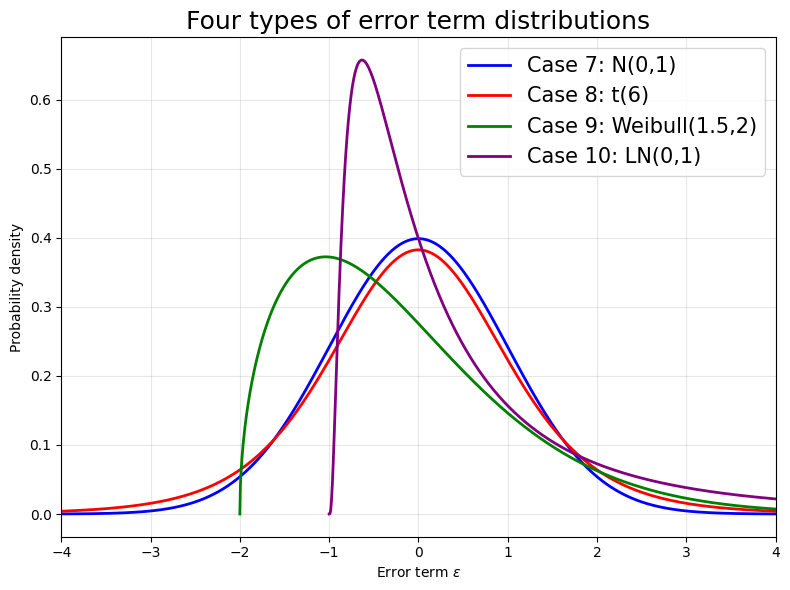

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t, weibull_min, lognorm
import seaborn as sns

# 创建数据点
x = np.linspace(-4, 4, 1000)

pdf1 = norm.pdf(x, 0, 1)
pdf2 = t.pdf(x, 6, 0, 1)
x_weibull = np.linspace(-2, 4, 1000)  # 调整x范围以适应偏移
# 韦布尔分布通常从0开始，我们通过位置参数使其以0为中心
shape = 1.5
scale = 2
# 创建以0为中心的韦布尔分布（通过位置参数平移）
pdf3 = weibull_min.pdf(x_weibull + scale, shape, scale=scale)

x_lognorm = np.linspace(-1, 4, 1000)
s = 1  # σ=1
scale_ln = np.exp(0)  # μ=0
pdf4 = lognorm.pdf(x_lognorm + scale_ln, s, scale=scale_ln)


# 为了更好的比较，再画一个所有分布在一起的图
plt.figure(figsize=(8, 6))

plt.plot(x, pdf1, 'b-', linewidth=2, label='Case 7: N(0,1)')
plt.plot(x, pdf2, 'r-', linewidth=2, label='Case 8: t(6)')
plt.plot(x_weibull, pdf3, 'g-', linewidth=2, label='Case 9: Weibull(1.5,2)')
plt.plot(x_lognorm, pdf4, 'purple', linewidth=2, label='Case 10: LN(0,1)')

plt.title('Four types of error term distributions', fontsize=18)
plt.xlabel('Error term $\epsilon$')
plt.ylabel('Probability density')
plt.legend(fontsize=15)
plt.grid(True, alpha=0.3)
plt.xlim(-4, 4)
plt.tight_layout()
# plt.show()
plt.savefig('C:/Users/Administrator/Desktop/pycox-master/examples/TranSurv/2025.08.28/AFT/AFT-2025.09.15.pdf')

In [5]:
result= pd.read_csv('C:/Users/Administrator/Desktop/pycox-master/examples/TranSurv/2025.08.28/AFT/result.csv',header=None)
df = pd.DataFrame(result)
df2 = df.to_numpy()
print(df2.shape)
print(df2)
Mean_cindex=df2[:,0:4]*100
Mean_ibs=df2[:,4:8]*100

(5, 8)
[[0.652 0.638 0.634 0.657 0.063 0.055 0.066 0.093]
 [0.639 0.623 0.616 0.631 0.064 0.056 0.067 0.095]
 [0.616 0.616 0.619 0.652 0.072 0.059 0.069 0.096]
 [0.611 0.55  0.545 0.517 0.064 0.056 0.066 0.092]
 [0.627 0.606 0.546 0.526 0.062 0.056 0.066 0.097]]


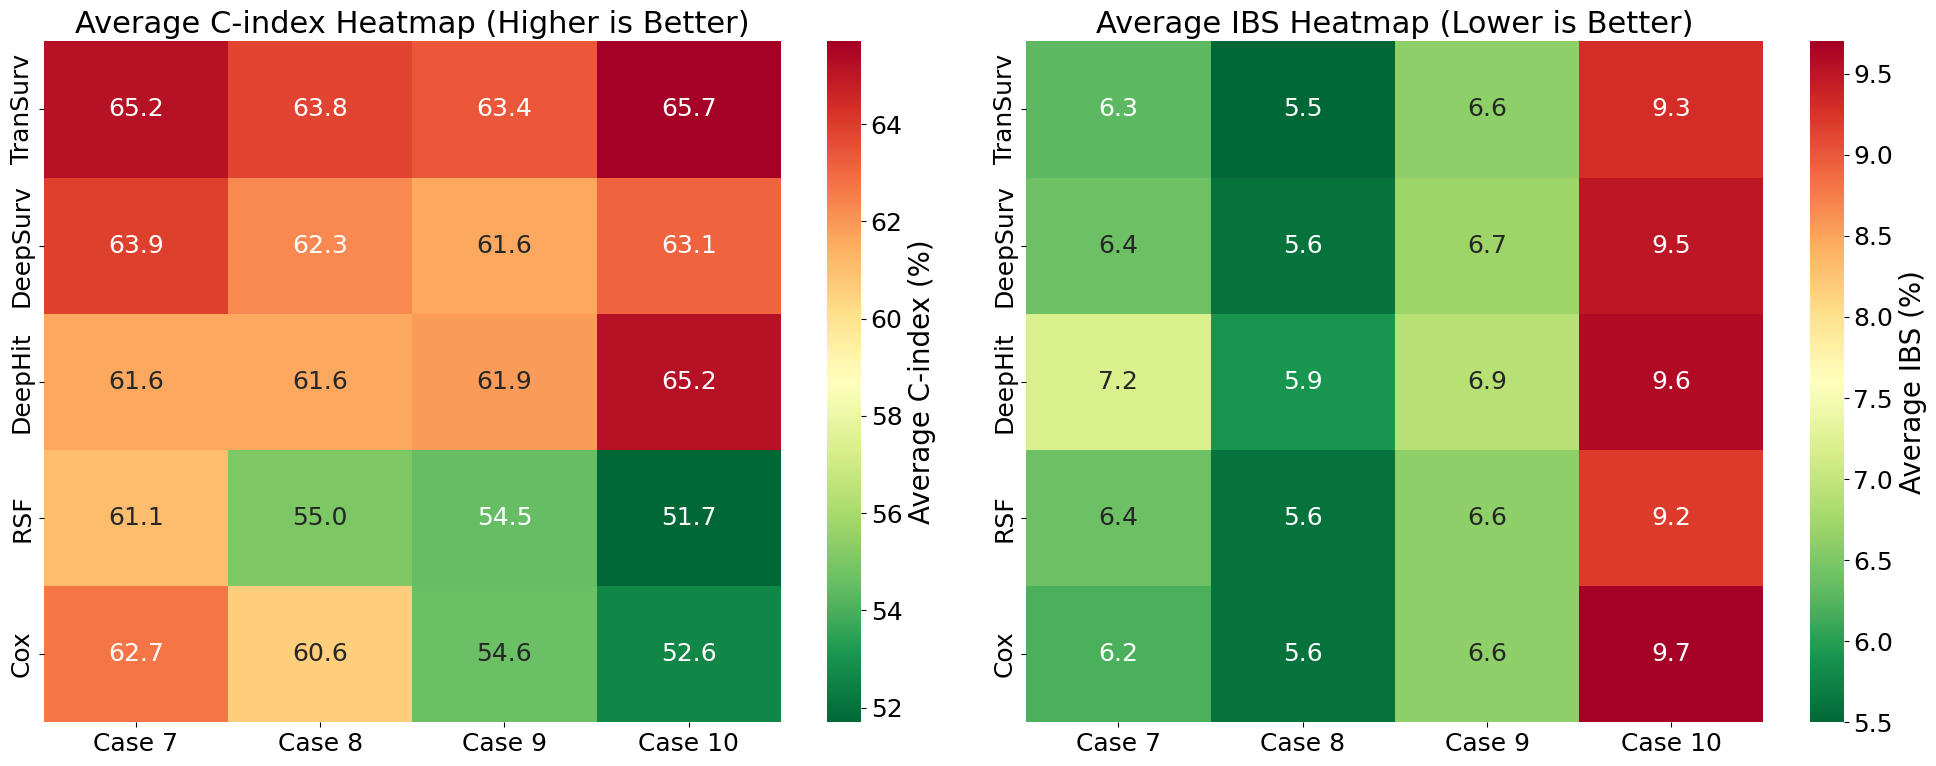

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['font.size'] = 18

# 准备数据
model_names = ['TranSurv', 'DeepSurv', 'DeepHit', 'RSF', 'Cox']
cases = ['Case 7', 'Case 8', 'Case 9', 'Case 10']
metrics = ['C-index', 'IBS']

# 创建图形
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# C-index 热力图
df_cindex = pd.DataFrame(Mean_cindex, index=model_names, columns=cases)
sns.heatmap(df_cindex, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax1, annot_kws={'size': 18})
ax1.set_title('Average C-index Heatmap (Higher is Better)', fontsize=22)
# 设置坐标轴标签字体大小
ax1.tick_params(axis='x', labelsize=18)
ax1.tick_params(axis='y', labelsize=18)

# IBS 热力图
df_ibs = pd.DataFrame(Mean_ibs, index=model_names, columns=cases)
sns.heatmap(df_ibs, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax2)
ax2.set_title('Average IBS Heatmap (Lower is Better)', fontsize=22)
# 设置坐标轴标签字体大小
ax2.tick_params(axis='x', labelsize=18)
ax2.tick_params(axis='y', labelsize=18)


# 调整颜色条标签字体大小
cbar1 = ax1.collections[0].colorbar
cbar1.ax.tick_params(labelsize=18)
cbar1.ax.set_ylabel('Average C-index (%)', fontsize=20)

cbar2 = ax2.collections[0].colorbar
cbar2.ax.tick_params(labelsize=18)
cbar2.ax.set_ylabel('Average IBS (%)', fontsize=20)


plt.tight_layout()
# plt.show()
plt.savefig('C:/Users/Administrator/Desktop/pycox-master/examples/TranSurv/2025.08.28/AFT/AFT-Heatmap-2025.09.15.pdf')